# Wind diffusion and drift

China map: https://emissions.aeronomie.be/index.php/omi-based/anthropogenic

In [8]:
# !pip install ffmpeg-python

In [1]:
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.windblow import WindBlow
from myext import  WindBlow2
%matplotlib inline

In [6]:
import opendrift
print(opendrift.__version__)

1.11.1


In [ ]:
# from IPython.display import HTML
# HTML(anim.to_html5_video())

## Forward

In [2]:
o = WindBlow2(loglevel=20)  # Set loglevel to 0 for debug information
# print(o)

# reader_arome = reader_netCDF_CF_generic.Reader('https://thredds.met.no/thredds/dodsC/mepslatest/meps_lagged_6_h_latest_2_5km_latest.nc')
# reader_arome = reader_netCDF_CF_generic.Reader(o.test_data_folder() +
#     '2Feb2016_Nordic_sigma_3d/AROME_MetCoOp_00_DEF_20160202_subset.nc')
reader_arome = reader_netCDF_CF_generic.Reader('AROME_MetCoOp_00_DEF_20160202_subset.nc')

o.add_reader([reader_arome])

21:57:24 INFO    opendrift.models.basemodel:528: OpenDriftSimulation initialised (version 1.11.1)
21:57:24 INFO    opendrift.readers.reader_netCDF_CF_generic:97: Opening dataset: AROME_MetCoOp_00_DEF_20160202_subset.nc
21:57:25 INFO    opendrift.readers.reader_netCDF_CF_generic:309: Detected dimensions: {'time': 'time', 'x': 'x', 'y': 'y'}


In [3]:
lat = 68.5; lon = 16.0  # Lofoten
# lat = 70.1; lon = 19
o.seed_elements(lon, lat, radius=5000, number=1000,
                time=reader_arome.start_time)
o.run(steps=48*4, time_step=900, time_step_output=3600, outfile='wind-last.nc')

21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 12:00:00 - step 1 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 12:15:00 - step 2 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 12:30:00 - step 3 of 192 - 1000 active elements (0 deactivated)


21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 12:45:00 - step 4 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 13:00:00 - step 5 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 13:15:00 - step 6 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 13:30:00 - step 7 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 13:45:00 - step 8 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 14:00:00 - step 9 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 14:15:00 - step 10 of 192 - 1000 active elements (0 deactivated)
21:57:35 INFO    opendrift.models.basemodel:1992: 2016-02-02 14:30:00 - step 11 of 192 - 1000 active elements (0 deactivated

In [4]:
# print(o)
o.animation(ocean_color='skyblue', land_color='burlywood', filename='wind-fwd.mp4')
# if o.anim is not None:
#     from IPython.display import HTML
#     HTML(o.anim.to_html5_video())

21:57:53 INFO    opendrift.models.basemodel:4525: Saving animation to wind-fwd.mp4...


49


21:58:27 INFO    opendrift.models.basemodel:2997: Time to make animation: 0:00:40.303662


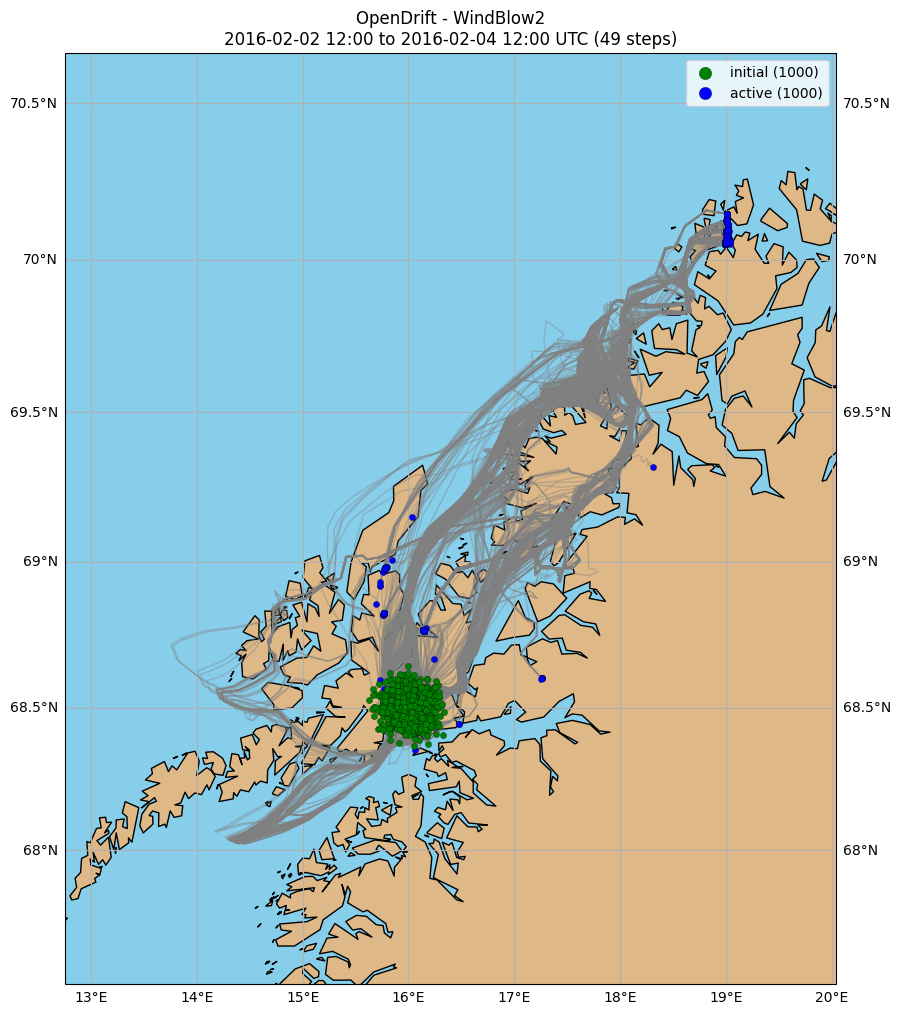

(<GeoAxes: title={'center': 'OpenDrift - WindBlow2\n2016-02-02 12:00 to 2016-02-04 12:00 UTC (49 steps)'}>,
 <Figure size 910.87x1100 with 1 Axes>)

In [5]:
o.plot(buffer=.5, ocean_color='skyblue', land_color='burlywood')

## Back tracking

1. backwards simulation from position where object is found (‘Observation’) 
2. forwards simulation from a uniform grid of possible initial locations, selecting the origins of particles actually hitting the observed target

In [2]:
import os
from datetime import timedelta
from tracemalloc import start
import cmocean
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import opendrift
from opendrift.readers import reader_netCDF_CF_generic
from myext import  WindBlow2

start-end time: 2016-02-02 12:00:00 2016-02-04 12:00:00
corners: [13.0, 19.495000000001014, 68.0, 70.49499999999773]


22:40:59 DEBUG   opendrift.config:161: Adding 15 config items from __init__
22:40:59 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
22:40:59 DEBUG   opendrift.config:161: Adding 2 config items from __init__
22:40:59 INFO    opendrift.models.basemodel:528: OpenDriftSimulation initialised (version 1.11.1)
22:40:59 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from wind-init.nc
22:40:59 INFO    opendrift:118: Returning <class 'myext.WindBlow2'> object
22:40:59 INFO    opendrift.models.basemodel:3826: 	calculating for origin_marker 0...
22:40:59 DEBUG   opendrift.models.basemodel:2313: Setting up map: corners=[13.0, 19.495000000001014, 68.0, 70.49499999999773], fast=True, lscale=None
22:40:59 WARNING opendrift.models.basemodel:2359: Plotting fast. This will make your plots less accurate.


max value <xarray.DataArray 'density_origin_marker' ()> Size: 8B
array(99.82333333)
Coordinates:
    time           datetime64[ns] 8B 2016-02-02T12:00:00
    origin_marker  int64 8B 0


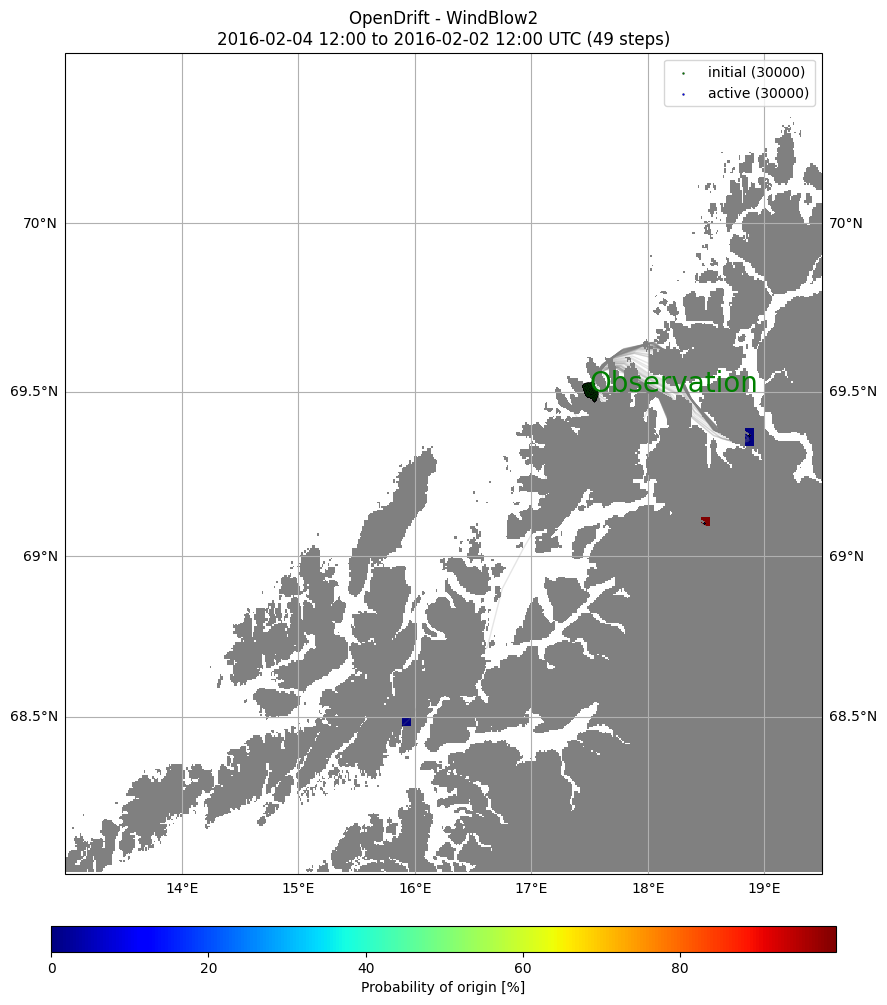

In [3]:
# o = Leeway(loglevel=50)
o = WindBlow2(loglevel=50)
# reader_arome = reader_netCDF_CF_generic.Reader(o.test_data_folder() +
#     '16Nov2015_NorKyst_z_surface/arome_subset_16Nov2015.nc')
reader_arome = reader_netCDF_CF_generic.Reader('AROME_MetCoOp_00_DEF_20160202_subset.nc')
# reader_norkyst = reader_netCDF_CF_generic.Reader(o.test_data_folder() +
#     '16Nov2015_NorKyst_z_surface/norkyst800_subset_16Nov2015.nc')
o.add_reader([ #reader_norkyst, 
              reader_arome])

duration = timedelta(hours=48)
# start_time = reader_norkyst.start_time
start_time = reader_arome.start_time
end_time = start_time + duration
print("start-end time:", start_time, end_time)

object_type = 26  # 26 = Life-raft, no ballast
outfile = 'wind-init.nc'
ilon = 17.5  # Incident position
ilat = 69.5
text = [{'s': 'Observation', 'x': ilon, 'y': ilat, 'fontsize': 20, 'color': 'g', 'zorder': 1000}]

# Define domain of possible origin
lons = np.arange(13, 19.5, .1/20)
lats = np.arange(68, 70.5, .1/20)
corners = [lons[0], lons[-1], lats[0], lats[-1]]
print("corners:", corners)
lons, lats = np.meshgrid(lons, lats)


# o.seed_elements(lon=ilon, lat=ilat, radius=5000, radius_type='uniform', number=30000, time=end_time, object_type=object_type)
o.seed_elements(lon=ilon, lat=ilat, radius=3000, radius_type='uniform', number=30000, time=end_time)
o.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile)
od = opendrift.open_xarray(outfile)
density_backwards = od.get_histogram(pixelsize_m=3000).isel(time=-1).isel(origin_marker=0)
density_backwards = density_backwards.where(density_backwards>0)
density_backwards = density_backwards/density_backwards.sum()*100
vmax = density_backwards.max()
print("max value", vmax)
o.plot(background=density_backwards, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.2, vmin=0, vmax=vmax)
os.remove(outfile)

## forward and hit


In [4]:
o = WindBlow2(loglevel=50)
o.add_reader([reader_arome])
o.seed_elements(lon=lons, lat=lats, radius=0, time=start_time)
o.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)
print(o)

22:42:59 DEBUG   opendrift.config:161: Adding 4 config items from environment
22:42:59 DEBUG   opendrift.config:161: Adding 5 config items from environment


--------------------
Reader performance:
--------------------
AROME_MetCoOp_00_DEF_20160202_subset.nc
 0:01:11.4  total
 0:00:00.9  preparing
 0:00:12.6  reading
 0:00:11.2  interpolation
 0:00:00.2  interpolation_time
 0:00:55.3  rotating vectors
 0:00:02.1  masking
--------------------
Performance:
 3:23.7 total time
    2.1 configuration
   11.2 preparing main loop
 3:08.7 main loop
     41.7 updating elements
    1.5 cleaning up
--------------------
Model:	WindBlow2     (OpenDrift version 1.11.1)
	650000 active PassiveTracer particles  (0 deactivated, 0 scheduled)
-------------------
Environment variables:
  -----
  x_wind
  y_wind
     1) AROME_MetCoOp_00_DEF_20160202_subset.nc

Discarded readers:

Time:
	Start: 2016-02-02 12:00:00 UTC
	Present: 2016-02-04 12:00:00 UTC
	Calculation steps: 192 * 0:15:00 - total time: 2 days, 0:00:00
	Output steps: 49 * 1:00:00



In [5]:
lon, lat = o.get_lonlats()
lonend = lon[:, -1]
latend = lat[:, -1]
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lonend.shape)
dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon*on, ilat*on)
hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfile, elements=hits)

o.animation(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], fast=True, 
            corners=corners, text=text, filename='wind-bckfwd.mp4')


22:47:10 DEBUG   opendrift.config:161: Adding 15 config items from __init__
22:47:10 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
22:47:10 DEBUG   opendrift.config:161: Adding 2 config items from __init__
22:47:10 INFO    opendrift.models.basemodel:528: OpenDriftSimulation initialised (version 1.11.1)
22:47:10 DEBUG   opendrift.export.io_netcdf:271: Importing from wind-init.nc
22:47:10 DEBUG   opendrift.models.basemodel:1666: No elements to deactivate
22:47:10 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: environment:constant:x_wind -> None
22:47:10 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: environment:fallback:x_wind -> 0
22:47:10 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: environment:constant:y_wind -> None
22:47:10 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: environment:fallback:y_wind -> 0
22:47:10 DEBUG   opendrift.export.io_netcdf:370: Setting imported confi

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
o.plot(compare=o_hit, 
       legend=['Elements not hitting target', 'Elements hitting target'], 
       show_elements=False, 
       fast=True, corners=corners, text=text)

In [ ]:
of = opendrift.open_xarray(outfile, elements=hits)
density_forwards = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_forwards = density_forwards.where(density_forwards>0)
o_hit.plot(background=density_forwards/density_forwards.sum()*100, 
           clabel='Probability of origin [%]', text=text, corners=corners, 
           fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)

In [3]:
import os
from datetime import timedelta
import cmocean
import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import opendrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.leeway import Leeway
from myext import  WindBlow2

In [18]:
# o = Leeway(loglevel=50)
o = WindBlow2(loglevel=50)
# reader_arome = reader_netCDF_CF_generic.Reader(o.test_data_folder() +
#     '16Nov2015_NorKyst_z_surface/arome_subset_16Nov2015.nc')
reader_arome = reader_netCDF_CF_generic.Reader('arome_subset_16Nov2015.nc')
# reader_norkyst = reader_netCDF_CF_generic.Reader(o.test_data_folder() +
#     '16Nov2015_NorKyst_z_surface/norkyst800_subset_16Nov2015.nc')
o.add_reader([ #reader_norkyst, 
              reader_arome])

duration = timedelta(hours=1)
# start_time = reader_norkyst.start_time
start_time = reader_arome.start_time
end_time = start_time + duration

object_type = 26  # 26 = Life-raft, no ballast
outfile = 'leeway.nc'
ilon = 4.3  # Incident position
ilat = 60.6
text = [{'s': 'Observation', 'x': ilon, 'y': ilat, 'fontsize': 20, 'color': 'g', 'zorder': 1000}]

# Define domain of possible origin
lons = np.arange(3.4, 5, .1/20)
lats = np.arange(59.7, 60.8, .05/20)
corners = [lons[0], lons[-1], lats[0], lats[-1]]
lons, lats = np.meshgrid(lons, lats)

### Method-1: backward 24-hour

22:29:13 DEBUG   opendrift.config:161: Adding 15 config items from __init__
22:29:13 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
22:29:13 DEBUG   opendrift.config:161: Adding 2 config items from __init__
22:29:13 INFO    opendrift.models.basemodel:528: OpenDriftSimulation initialised (version 1.11.1)
22:29:13 DEBUG   opendrift.export.io_netcdf:216: Importing with Xarray from leeway.nc
22:29:13 INFO    opendrift:118: Returning <class 'myext.WindBlow2'> object
22:29:13 INFO    opendrift.models.basemodel:3826: 	calculating for origin_marker 0...
22:29:13 DEBUG   opendrift.models.basemodel:2313: Setting up map: corners=[3.4, 4.9949999999999655, 59.7, 60.797499999999005], fast=True, lscale=None
22:29:13 WARNING opendrift.models.basemodel:2359: Plotting fast. This will make your plots less accurate.


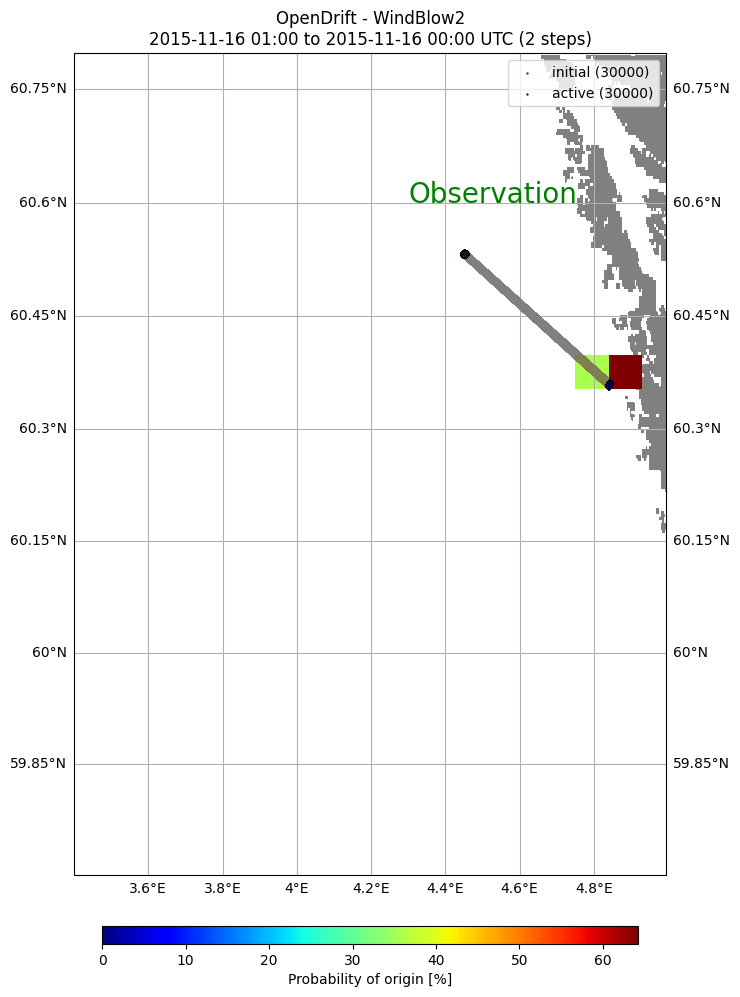

In [19]:
# o.seed_elements(lon=ilon, lat=ilat, radius=5000, radius_type='uniform', number=30000, time=end_time, object_type=object_type)
o.seed_elements(lon=ilon, lat=ilat, radius=500, radius_type='uniform', number=30000, time=end_time)
o.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile)
od = opendrift.open_xarray(outfile)
density_backwards = od.get_histogram(pixelsize_m=5000).isel(time=-1).isel(origin_marker=0)
density_backwards = density_backwards.where(density_backwards>0)
density_backwards = density_backwards/density_backwards.sum()*100
vmax = density_backwards.max()
o.plot(background=density_backwards, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)
os.remove(outfile)

### Method-2: forward and hit

1. starting at a uniform grid 24 hours earlier (440 x 320 = 140800 elements at ~500m separation)
2. Finding the elements actually hitting the target (within 5 km) after 24 hours:

In [ ]:
o = Leeway(loglevel=50)
# o.add_reader([reader_norkyst, reader_arome])
o.add_reader([reader_arome])
o.seed_elements(lon=lons, lat=lats, radius=0,
                 time=start_time, object_type=object_type)
o.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile)
print(o)

In [ ]:
lon, lat = o.get_lonlats()
lonend = lon[:, -1]
latend = lat[:, -1]
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lonend.shape)
dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon*on, ilat*on)
hits = np.where(dist2incident<5000)[0]
hit_start_lons = lon[hits, 0]
hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfile, elements=hits)

o.animation(compare=o_hit, legend=['Elements not hitting target', 'Elements hitting target'], fast=True, corners=corners, text=text)


In [ ]:
o.plot(compare=o_hit, 
       legend=['Elements not hitting target', 'Elements hitting target'], 
       show_elements=False, 
       fast=True, corners=corners, text=text)

In [ ]:
of = opendrift.open_xarray(outfile, elements=hits)
density_forwards = of.get_histogram(pixelsize_m=5000).isel(time=0).isel(origin_marker=0)
density_forwards = density_forwards.where(density_forwards>0)
o_hit.plot(background=density_forwards/density_forwards.sum()*100, 
           clabel='Probability of origin [%]', text=text, corners=corners, 
           fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)

## Resources

* https://opendrift.github.io/gallery/example_windblow.html